In [1]:
import numpy as np
import matplotlib.pyplot as plt

from joblib import Parallel, delayed, parallel_backend
import pandas as pd

from decrease_bound_utils import psiam_tied_data_gen_wrapper_bound_change

# Params

In [2]:
V_A = 1.1
theta_A = 1.8

rate_lambda = 0.14
T_0 = 0.66 * (1e-3)
theta_E = 40.5

t_A_aff = 0.03
t_E_aff = 0.05
t_motor = 0.03

Z_E = 0
L = 0.5

N_sim = int(50e3)
dt = 1e-4

bound_step_size = 3
N_print = int(10e3)

# ABL, ILD, stim and led times from data

In [3]:
og_df = pd.read_csv('../out_LED.csv')
df = og_df[ og_df['repeat_trial'].isin([0,2]) | og_df['repeat_trial'].isna() ]
session_type = 7    
df = df[ df['session_type'].isin([session_type]) ]
training_level = 16
df = df[ df['training_level'].isin([training_level]) ]

t_stim_and_led_tuple = [(row['intended_fix'], row['LED_onset_time']) for _, row in df.iterrows()]

ABL_arr = df['ABL'].unique()
ABL_arr.sort()

ILD_arr = df['ILD'].unique()
ILD_arr.sort()

# percentage of LED on trials
frac_of_led = df['LED_trial'].values.sum() / df['LED_trial'].values.size
print(f'frac_of_led: {frac_of_led}')

frac_of_led: 0.33939811074203746


# simulate many

In [4]:
bound_change_results_dict = {}
for i in range(5):
    new_bound = theta_E - i * bound_step_size

    with parallel_backend('threading', n_jobs=-1):
        sim_results = Parallel()(
            delayed(psiam_tied_data_gen_wrapper_bound_change)(V_A, theta_A, ABL_arr, ILD_arr, rate_lambda, T_0, theta_E, Z_E,\
                                                               t_A_aff, t_E_aff, t_motor, L,t_stim_and_led_tuple, new_bound, iter_num, \
                                                                N_print, dt)
            for iter_num in range(N_sim)
        )

    print(f'V_A: {V_A}, new bound: {new_bound}')

    bound_change_results_dict[i] = {'results': sim_results, 'new_bound':  new_bound }

os id: 1552729, In iter_num: 0, ABL: 40, ILD: 1.0, t_stim: 0.509158449383876
os id: 1552729, In iter_num: 10000, ABL: 40, ILD: 1.0, t_stim: 0.839512723495338
os id: 1552729, In iter_num: 20000, ABL: 40, ILD: -2.0, t_stim: 0.201074195956924
os id: 1552729, In iter_num: 30000, ABL: 40, ILD: -16.0, t_stim: 0.415481736121083
os id: 1552729, In iter_num: 40000, ABL: 20, ILD: -16.0, t_stim: 0.435517474369001
V_A: 1.1, new bound: 40.5
os id: 1552729, In iter_num: 0, ABL: 20, ILD: -8.0, t_stim: 0.913454673018143
os id: 1552729, In iter_num: 10000, ABL: 40, ILD: 1.0, t_stim: 0.318977954421279
os id: 1552729, In iter_num: 20000, ABL: 40, ILD: -2.0, t_stim: 0.261151460833622
os id: 1552729, In iter_num: 30000, ABL: 60, ILD: -16.0, t_stim: 0.883057480413818
os id: 1552729, In iter_num: 40000, ABL: 20, ILD: -4.0, t_stim: 0.213781572427531
V_A: 1.1, new bound: 37.5
os id: 1552729, In iter_num: 0, ABL: 20, ILD: 2.0, t_stim: 0.245433371486034
os id: 1552729, In iter_num: 10000, ABL: 20, ILD: -8.0, t_s

# see aborts distr

In [5]:
new_bound_ON = []
control_bound_ON = []

new_bound_off = []
control_bound_off = []

for res in bound_change_results_dict[0]['results']:
    if res['is_LED_trial']:
        if res['rt'] > res['t_led'] and res['rt'] < res['t_stim']:
            new_bound_ON.append(res['rt'] - res['t_stim'])
    elif not res['is_LED_trial']:
        if res['rt'] > res['t_led'] and res['rt'] < res['t_stim']:
            new_bound_off.append(res['rt'] - res['t_stim'])

for res in bound_change_results_dict[4]['results']:
    if res['is_LED_trial']:
        if res['rt'] > res['t_led'] and res['rt'] < res['t_stim']:
            control_bound_ON.append(res['rt'] - res['t_stim'])
    elif not res['is_LED_trial']:
        if res['rt'] > res['t_led'] and res['rt'] < res['t_stim']:
            control_bound_off.append(res['rt'] - res['t_stim'])

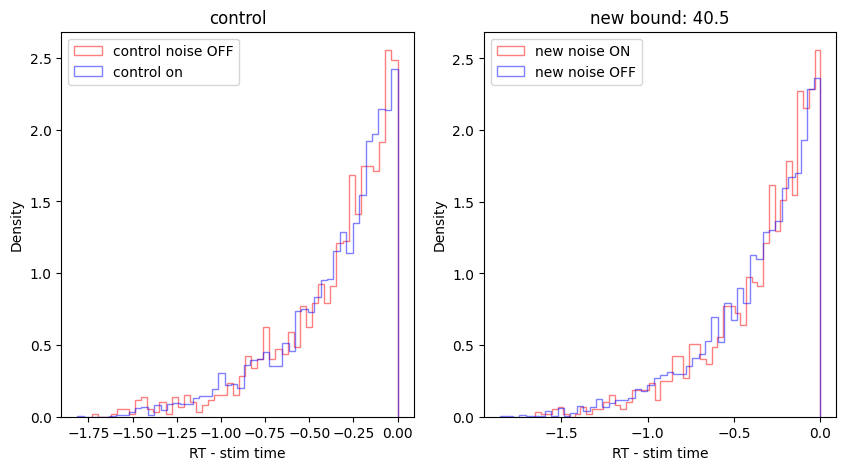

In [6]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.hist(control_bound_ON, bins=50, alpha=0.5,  density=True, label='control noise OFF', color='r', histtype='step')
plt.hist(control_bound_off, bins=50, alpha=0.5, density=True, label='control on', color='b', histtype='step')
plt.title('control')
plt.xlabel('RT - stim time')
plt.ylabel('Density')
plt.legend()

plt.subplot(1,2,2)
plt.hist(new_bound_ON, bins=50, alpha=0.5,  density=True, label='new noise ON', color='r', histtype='step')
plt.hist(new_bound_off, bins=50, alpha=0.5,  density=True, label='new noise OFF', color='b', histtype='step')
plt.title(f'new bound: {bound_change_results_dict[0]["new_bound"]}')
plt.xlabel('RT - stim time')
plt.ylabel('Density')
plt.legend()

# psychometric

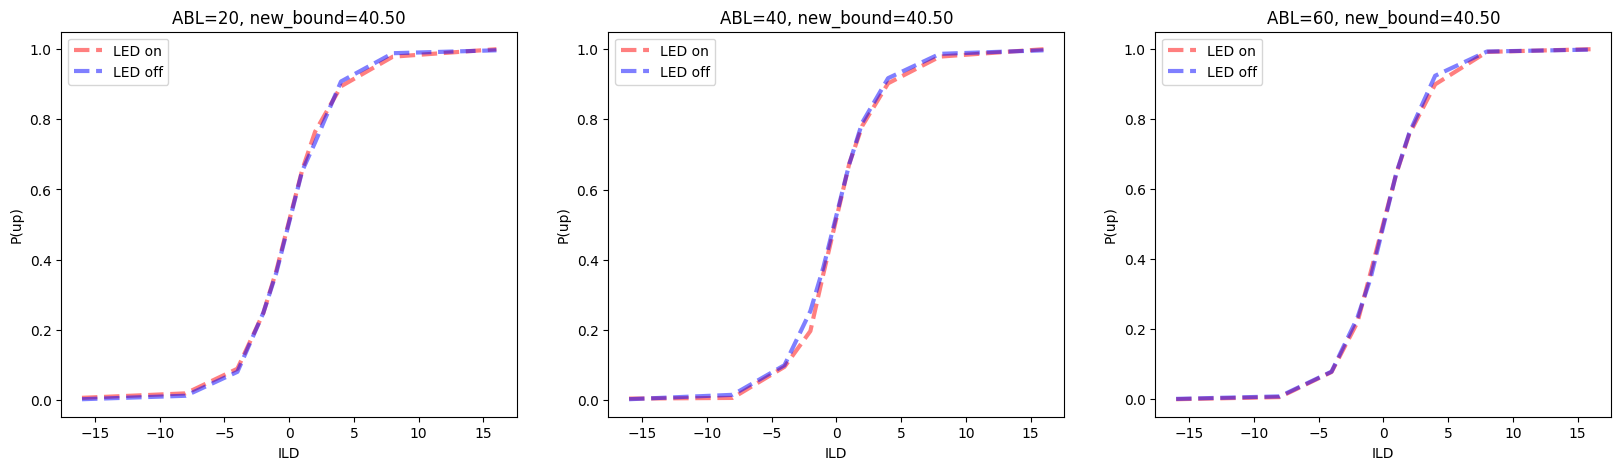

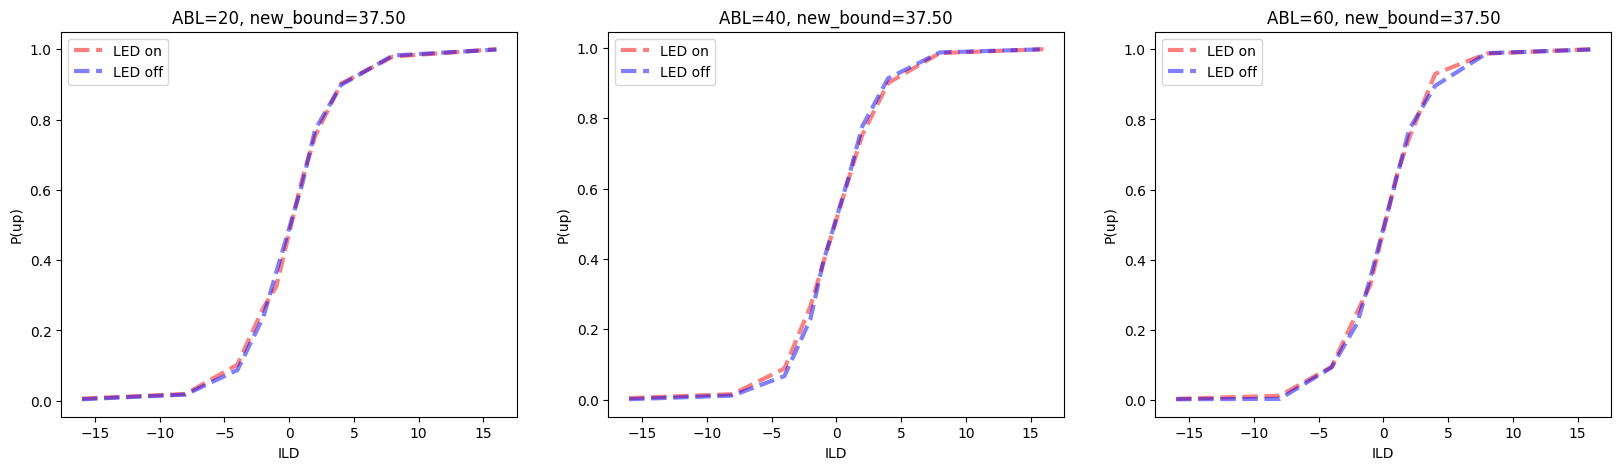

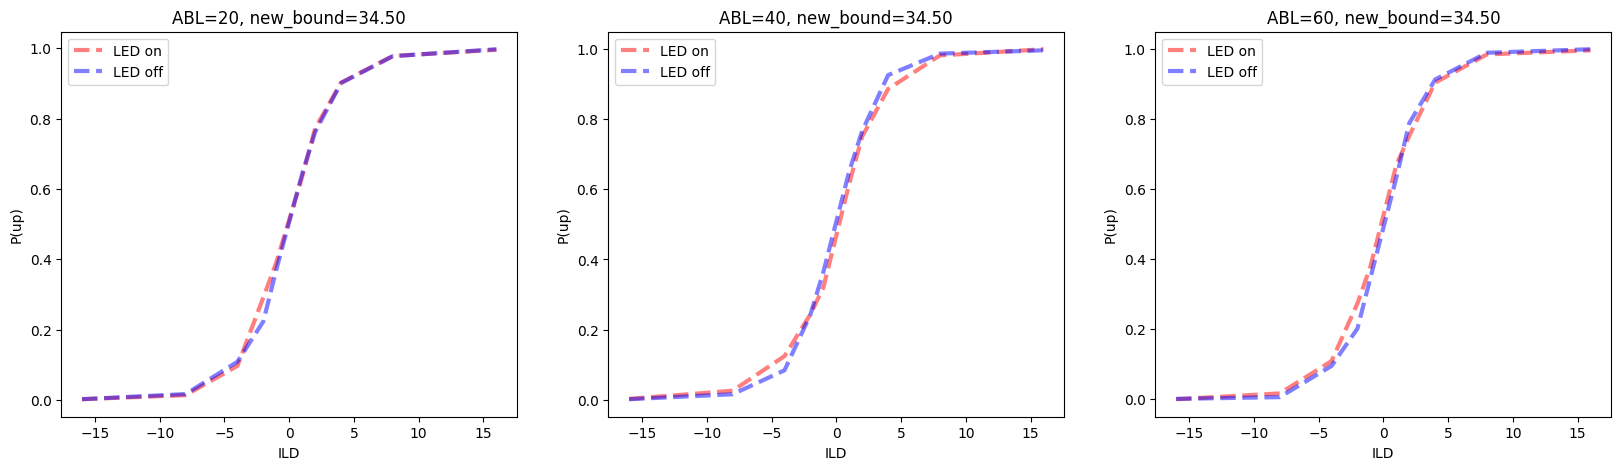

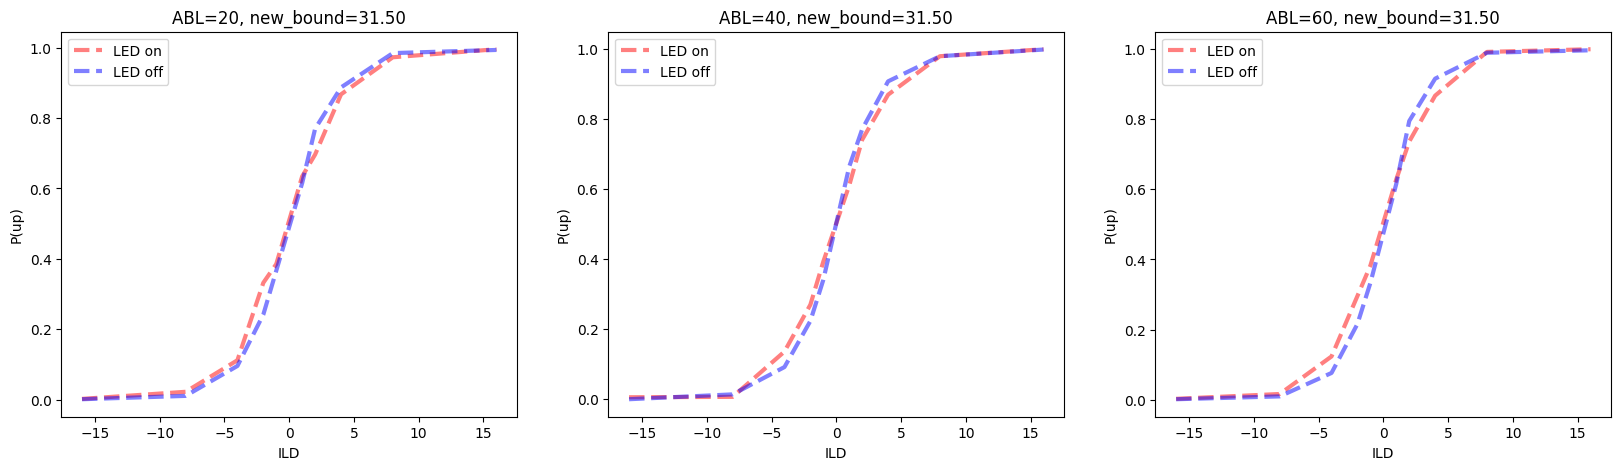

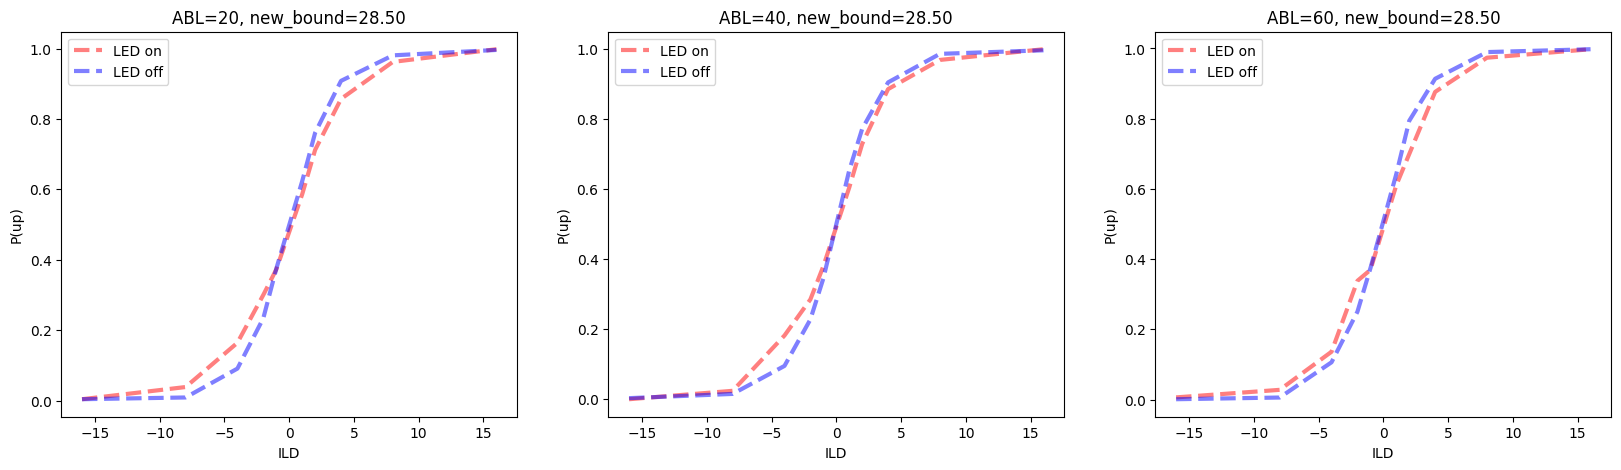

In [7]:
for i in range(0, 5):
    # for each V_A
    each_bound_results = bound_change_results_dict[i]['results']
    new_bound = bound_change_results_dict[i]['new_bound']

    num_up_on = {}; num_trials_on = {}
    num_up_off = {}; num_trials_off = {}
    for ABL in ABL_arr:
        num_up_on[ABL] = np.zeros_like(ILD_arr)
        num_trials_on[ABL] = np.zeros_like(ILD_arr)

        num_up_off[ABL] = np.zeros_like(ILD_arr)
        num_trials_off[ABL] = np.zeros_like(ILD_arr)

    
    for res in each_bound_results:
        ABL = res['ABL']
        ILD = res['ILD']
        is_LED_trial = res['is_LED_trial']
        if is_LED_trial:
            if res['rt'] > res['t_stim'] and res['rt'] > res['t_led']:
                num_trials_on[ABL][int(np.where(ILD_arr == ILD)[0][0])] += 1
                if res['choice'] == 1:
                    num_up_on[ABL][int(np.where(ILD_arr == ILD)[0][0])] += 1
        elif not is_LED_trial:
            if res['rt'] > res['t_stim'] and res['rt'] > res['t_led']:
                num_trials_off[ABL][int(np.where(ILD_arr == ILD)[0][0])] += 1
                if res['choice'] == 1:
                    num_up_off[ABL][int(np.where(ILD_arr == ILD)[0][0])] += 1

        

        

    plt.figure(figsize=(20,5))
    for a, ABL in enumerate(ABL_arr):
        plt.subplot(1, len(ABL_arr), a+1)
        plt.title(f'ABL={ABL}, new_bound={new_bound:.2f}')

        
        plt.plot(ILD_arr, num_up_on[ABL]/num_trials_on[ABL], label='LED on', linestyle='--', color='r', lw=3, alpha=0.5)
        plt.plot(ILD_arr, num_up_off[ABL]/num_trials_off[ABL], label='LED off', linestyle='--', color='b', lw=3, alpha=0.5)
        
        plt.legend()
        plt.xlabel('ILD'); plt.ylabel('P(up)');

# percentiles

In [19]:
base_bound_data = bound_change_results_dict[0]['results']


# change V_A
new_bound_idx = 3
new_bound_value = bound_change_results_dict[new_bound_idx]['new_bound']
new_bound_data = bound_change_results_dict[new_bound_idx]['results']

In [20]:
base_on_abl_ild = {}
base_off_abl_ild = {}

new_on_abl_ild = {}
new_off_abl_ild = {}

for ABL in ABL_arr:
    for ILD in ILD_arr:
        base_on_abl_ild[(ABL, int(ILD))] = []
        base_off_abl_ild[(ABL, int(ILD))] = []

        new_on_abl_ild[(ABL, int(ILD))] = []
        new_off_abl_ild[(ABL, int(ILD))] = []

for res in base_bound_data:
    ABL = res['ABL']
    ILD = res['ILD']
    is_LED_trial = res['is_LED_trial']
    if is_LED_trial:
        if res['rt'] > res['t_led']:
            base_on_abl_ild[ABL, int(ILD)].append(res['rt'] - res['t_stim'])
    elif not is_LED_trial:
        if res['rt'] > res['t_led']:
            base_off_abl_ild[ABL, int(ILD)].append(res['rt'] - res['t_stim'])


for res in new_bound_data:
    ABL = res['ABL']
    ILD = res['ILD']
    is_LED_trial = res['is_LED_trial']
    if is_LED_trial:
        if res['rt'] > res['t_led']:
            new_on_abl_ild[ABL, int(ILD)].append(res['rt'] - res['t_stim'])
    elif not is_LED_trial:
        if res['rt'] > res['t_led']:
            new_off_abl_ild[ABL, int(ILD)].append(res['rt'] - res['t_stim'])

In [21]:
base_on_percentiles_dict = {}
base_off_percentiles_dict = {}

new_on_percentiles_dict = {}
new_off_percentiles_dict = {}

percentiles = [10, 30, 50, 70, 90]


for ABL in ABL_arr:
    base_on_percentiles_dict[ABL] = np.zeros((len(percentiles), len(ILD_arr)))
    base_off_percentiles_dict[ABL] = np.zeros((len(percentiles), len(ILD_arr)))

    new_on_percentiles_dict[ABL] = np.zeros((len(percentiles), len(ILD_arr)))
    new_off_percentiles_dict[ABL] = np.zeros((len(percentiles), len(ILD_arr)))


for ABL in ABL_arr:
    for ild_idx,ILD in enumerate(ILD_arr):
        for p, percentile in enumerate(percentiles):
            base_on_percentiles_dict[ABL][(p, ild_idx)] = np.percentile(base_on_abl_ild[ABL, int(ILD)], percentile)
            base_off_percentiles_dict[ABL][p, ild_idx] = np.percentile(base_off_abl_ild[ABL, int(ILD)], percentile)

            new_on_percentiles_dict[ABL][p, ild_idx] = np.percentile(new_on_abl_ild[ABL, int(ILD)], percentile)
            new_off_percentiles_dict[ABL][p, ild_idx] = np.percentile(new_off_abl_ild[ABL, int(ILD)], percentile)

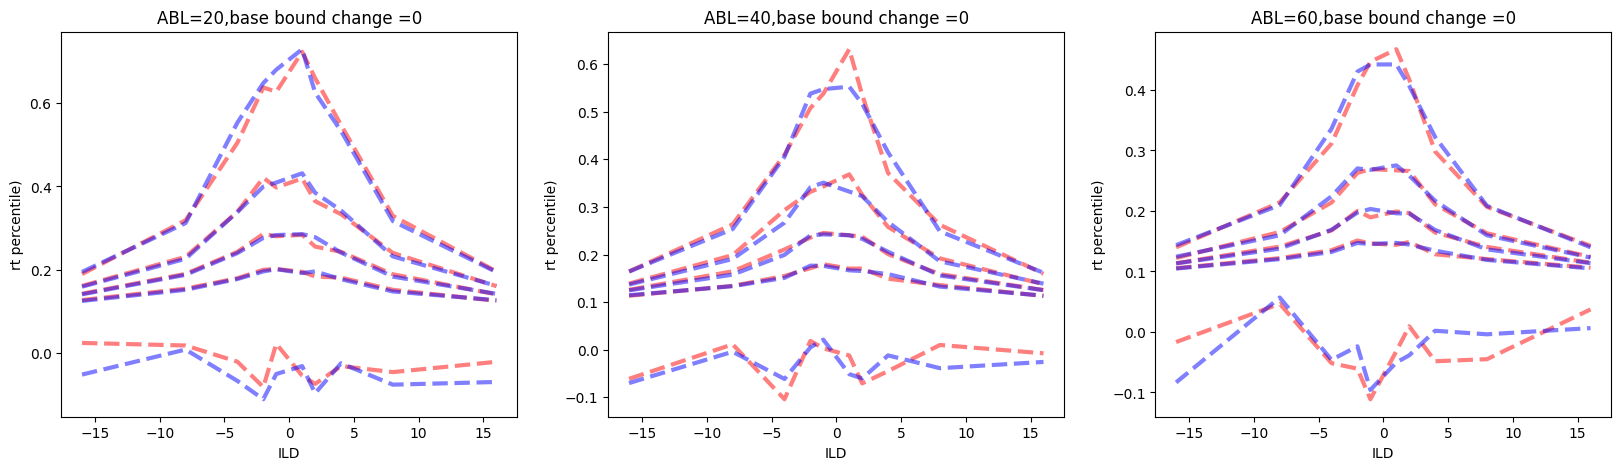

In [22]:
# plot
plt.figure(figsize=(20,5))
for a, ABL in enumerate(ABL_arr):
    plt.subplot(1, len(ABL_arr), a+1)
    plt.title(f'ABL={ABL},base bound change ={0}')
    for p, percentile in enumerate(percentiles):
        plt.plot(ILD_arr, base_on_percentiles_dict[ABL][p], label=f'base ON {percentile}', linestyle='--', color='r', lw=3, alpha=0.5)
        plt.plot(ILD_arr, base_off_percentiles_dict[ABL][p], label=f'base OFF {percentile}', linestyle='--', color='b', lw=3, alpha=0.5)



    plt.xlabel('ILD'); plt.ylabel('rt percentile)');

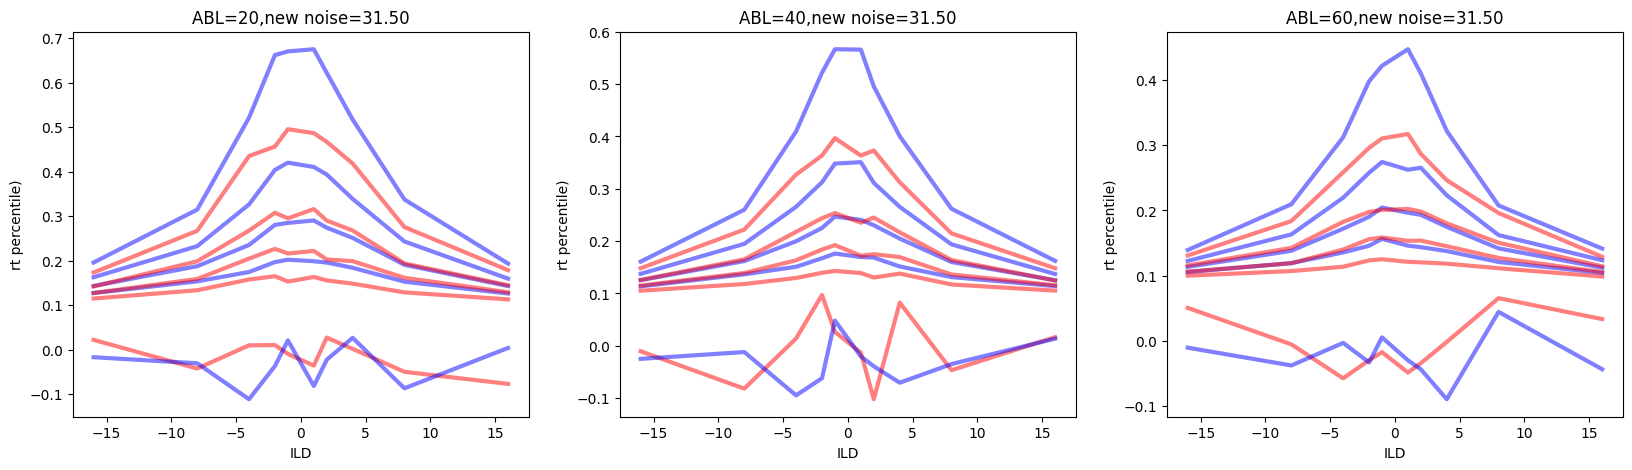

In [23]:


# plot
plt.figure(figsize=(20,5))
for a, ABL in enumerate(ABL_arr):
    plt.subplot(1, len(ABL_arr), a+1)
    plt.title(f'ABL={ABL},new noise={new_bound_value:.2f}')
    for p, percentile in enumerate(percentiles):
        plt.plot(ILD_arr, new_on_percentiles_dict[ABL][p], label=f'new ON {percentile}', linestyle='-', color='r', lw=3, alpha=0.5)
        plt.plot(ILD_arr, new_off_percentiles_dict[ABL][p], label=f'new OFF {percentile}', linestyle='-', color='b', lw=3, alpha=0.5)



    plt.xlabel('ILD'); plt.ylabel('rt percentile)');

# chronometric

In [24]:
positive_ILD_arr = ILD_arr[ILD_arr > 0]

In [25]:
# base and new init- collect rt
base_rt_abl_ild_on = {}
base_rt_abl_ild_off = {}

new_rt_abl_ild_on = {}
new_rt_abl_ild_off = {}

for ABL in ABL_arr:
    for ILD in positive_ILD_arr:
        base_rt_abl_ild_on[(ABL, ILD)] = []
        base_rt_abl_ild_off[(ABL, ILD)] = []

        new_rt_abl_ild_on[(ABL, ILD)] = []
        new_rt_abl_ild_off[(ABL, ILD)] = []

In [26]:
#  base
for res in base_bound_data:
    ABL = res['ABL']
    ILD = res['ILD']
    abs_ILD = np.abs(ILD)

    if res['is_LED_trial']:
        if res['rt'] > res['t_led']:
            base_rt_abl_ild_on[(ABL, abs_ILD)].append(res['rt'] - res['t_stim'])
    elif not res['is_LED_trial']:
        if res['rt'] > res['t_led']:
            base_rt_abl_ild_off[(ABL, abs_ILD)].append(res['rt'] - res['t_stim'])

# new
for res in new_bound_data:
    ABL = res['ABL']
    ILD = res['ILD']
    abs_ILD = np.abs(ILD)

    if res['is_LED_trial']:
        if res['rt'] > res['t_led']:
            new_rt_abl_ild_on[(ABL, abs_ILD)].append(res['rt'] - res['t_stim'])
    elif not res['is_LED_trial']:
        if res['rt'] > res['t_led']:
            new_rt_abl_ild_off[(ABL, abs_ILD)].append(res['rt'] - res['t_stim'])

In [27]:
# base
base_on_mean = {}
base_on_std_err = {}

base_off_mean = {}
base_off_std_err = {}

for ABL in ABL_arr:
    for ILD in positive_ILD_arr:
        base_on_mean[(ABL, ILD)] = np.mean(base_rt_abl_ild_on[(ABL, ILD)])
        base_on_std_err[(ABL, ILD)] = np.std(base_rt_abl_ild_on[(ABL, ILD)]) / np.sqrt(len(base_rt_abl_ild_on[(ABL, ILD)]))

        base_off_mean[(ABL, ILD)] = np.mean(base_rt_abl_ild_off[(ABL, ILD)])
        base_off_std_err[(ABL, ILD)] = np.std(base_rt_abl_ild_off[(ABL, ILD)]) / np.sqrt(len(base_rt_abl_ild_off[(ABL, ILD)]))

In [28]:
# new
new_on_mean = {}
new_on_std_err = {}

new_off_mean = {}
new_off_std_err = {}

for ABL in ABL_arr:
    for ILD in positive_ILD_arr:
        new_on_mean[(ABL, ILD)] = np.mean(new_rt_abl_ild_on[(ABL, ILD)])
        new_on_std_err[(ABL, ILD)] = np.std(new_rt_abl_ild_on[(ABL, ILD)]) / np.sqrt(len(new_rt_abl_ild_on[(ABL, ILD)]))

        new_off_mean[(ABL, ILD)] = np.mean(new_rt_abl_ild_off[(ABL, ILD)])
        new_off_std_err[(ABL, ILD)] = np.std(new_rt_abl_ild_off[(ABL, ILD)]) / np.sqrt(len(new_rt_abl_ild_off[(ABL, ILD)]))

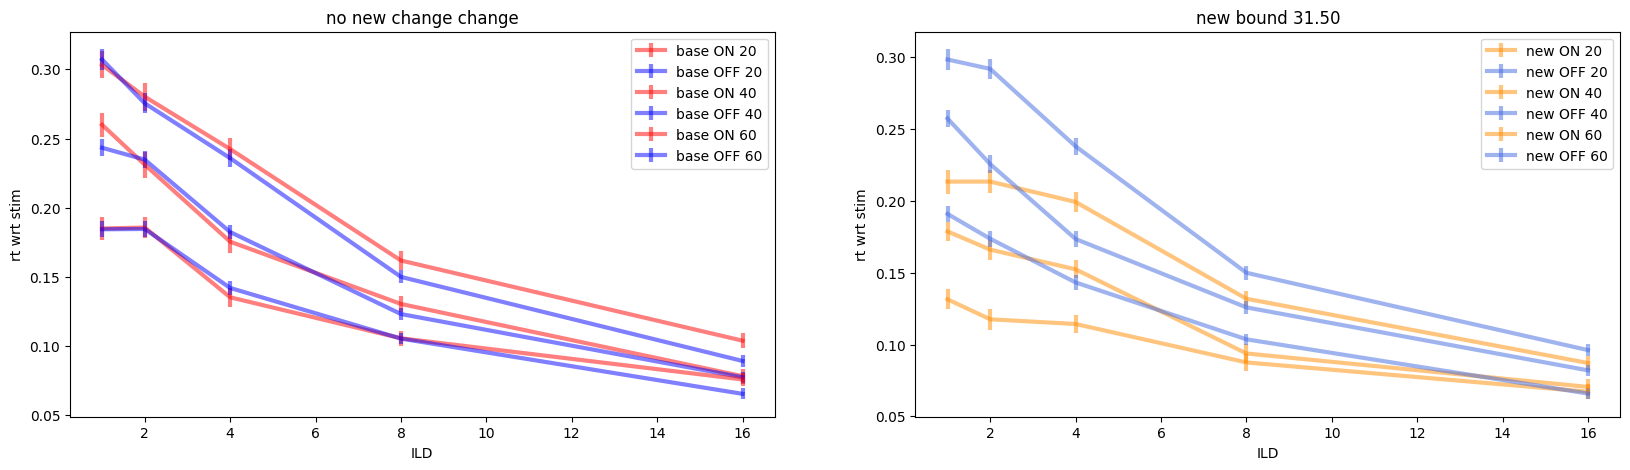

In [29]:
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
# base - mean with std err vs pos ILD
for ABL in ABL_arr:
    plt.errorbar(positive_ILD_arr, [base_on_mean[(ABL, ILD)] for ILD in positive_ILD_arr], yerr=[base_on_std_err[(ABL, ILD)] for ILD in positive_ILD_arr], label=f'base ON {ABL}', color='r', lw=3, alpha=0.5)
    plt.errorbar(positive_ILD_arr, [base_off_mean[(ABL, ILD)] for ILD in positive_ILD_arr], yerr=[base_off_std_err[(ABL, ILD)] for ILD in positive_ILD_arr], label=f'base OFF {ABL}', color='b', lw=3, alpha=0.5)
    plt.legend()
    plt.xlabel('ILD'); plt.ylabel('rt wrt stim')
    plt.title('no new change change')

plt.subplot(1,2,2)
# new - mean with std err vs pos ILD
for ABL in ABL_arr:
    plt.errorbar(positive_ILD_arr, [new_on_mean[(ABL, ILD)] for ILD in positive_ILD_arr], yerr=[new_on_std_err[(ABL, ILD)] for ILD in positive_ILD_arr], label=f'new ON {ABL}', color='darkorange', lw=3, alpha=0.5)
    plt.errorbar(positive_ILD_arr, [new_off_mean[(ABL, ILD)] for ILD in positive_ILD_arr], yerr=[new_off_std_err[(ABL, ILD)] for ILD in positive_ILD_arr], label=f'new OFF {ABL}', color='royalblue', lw=3, alpha=0.5)
    plt.legend()
    plt.xlabel('ILD'); plt.ylabel('rt wrt stim')
    plt.title(f'new bound {new_bound_value:.2f}')